In [2]:
!pip install kaggle

In [4]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
# set path to kaggle.json 
import os
os.environ['KAGGLE_CONFIG_DIR']="/content/gdrive/MyDrive/Kaggle"

In [4]:
os.chdir("/content/gdrive/MyDrive/Kaggle")

In [8]:
!kaggle competitions download -c jigsaw-toxic-comment-classification-challenge

test.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
sample_submission.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
test_labels.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
train.csv.zip: Skipping, found more recently modified local copy (use --force to force download)


In [9]:
#unzipping the zip files and deleting the zip files
!unzip \*.zip  && rm *.zip

Archive:  sample_submission.csv.zip
  inflating: sample_submission.csv   

Archive:  test_labels.csv.zip
  inflating: test_labels.csv         

Archive:  train.csv.zip
  inflating: train.csv               

Archive:  test.csv.zip
  inflating: test.csv                

4 archives were successfully processed.


Training Keras  Embedding layer to learn words vector representation of the given corpus

In [1]:
import sys,os,re,csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense,Input,LSTM,Embedding,Dropout,Activation
from keras.layers import Bidirectional,GlobalMaxPool1D
from keras.models import Model
from keras import initializers,regularizers,constraints,optimizers,layers

In [5]:
train=pd.read_csv("train.csv")
test=pd.read_csv("test.csv")

In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   id             159571 non-null  object
 1   comment_text   159571 non-null  object
 2   toxic          159571 non-null  int64 
 3   severe_toxic   159571 non-null  int64 
 4   obscene        159571 non-null  int64 
 5   threat         159571 non-null  int64 
 6   insult         159571 non-null  int64 
 7   identity_hate  159571 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 9.7+ MB


There are 6 target labels for classification. In the dataset, the labels are ont-hot encoded and presented as 6 columns to predict independently. we will use keras functional API to predict multiple outputs

In [7]:
train.head(10)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0
5,00025465d4725e87,"""\n\nCongratulations from me as well, use the ...",0,0,0,0,0,0
6,0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0
7,00031b1e95af7921,Your vandalism to the Matt Shirvington article...,0,0,0,0,0,0
8,00037261f536c51d,Sorry if the word 'nonsense' was offensive to ...,0,0,0,0,0,0
9,00040093b2687caa,alignment on this subject and which are contra...,0,0,0,0,0,0


# Preprocessing
A common preprocessing step is to check for nulls, and fill the null values with something before proceeding to the next steps. If you leave the null values intact, it will trip you up at the modelling stage late

Below code shows that we dont have any null value

In [8]:
train.isnull().any()

id               False
comment_text     False
toxic            False
severe_toxic     False
obscene          False
threat           False
insult           False
identity_hate    False
dtype: bool

In [9]:
test.isnull().any()

id              False
comment_text    False
dtype: bool

In [10]:
def clean_text(text):
  text=str(text)
  text=re.sub("[^a-zA-Z\s\.]",'',text)
  text=text.strip()
  text=text.lower()
  text=text.replace('\n',' ')

  return text

train['comment_text']=train['comment_text'].apply(lambda x : clean_text(x))

In [11]:
test['comment_text']=test['comment_text'].apply(lambda x : clean_text(x))

In [12]:
train.head(10)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,explanation why the edits made under my userna...,0,0,0,0,0,0
1,000103f0d9cfb60f,daww he matches this background colour im seem...,0,0,0,0,0,0
2,000113f07ec002fd,hey man im really not trying to edit war. its ...,0,0,0,0,0,0
3,0001b41b1c6bb37e,more i cant make any real suggestions on impro...,0,0,0,0,0,0
4,0001d958c54c6e35,you sir are my hero. any chance you remember w...,0,0,0,0,0,0
5,00025465d4725e87,congratulations from me as well use the tools ...,0,0,0,0,0,0
6,0002bcb3da6cb337,cocksucker before you piss around on my work,1,1,1,0,1,0
7,00031b1e95af7921,your vandalism to the matt shirvington article...,0,0,0,0,0,0
8,00037261f536c51d,sorry if the word nonsense was offensive to yo...,0,0,0,0,0,0
9,00040093b2687caa,alignment on this subject and which are contra...,0,0,0,0,0,0


In [13]:
classes=["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
y=train[classes].values
sentences_train=train['comment_text'].values
sentences_test=test['comment_text'].values

In [14]:
print(sentences_train[:3])
sentences_train.shape   # each sentence is a single element in the array

['explanation why the edits made under my username hardcore metallica fan were reverted they werent vandalisms just closure on some gas after i voted at new york dolls fac. and please dont remove the template from the talk page since im retired now....'
 'daww he matches this background colour im seemingly stuck with. thanks.  talk  january   utc'
 'hey man im really not trying to edit war. its just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page. he seems to care more about the formatting than the actual info.']


(159571,)

Preprocessing to feed data into Embedding layer
1. Vocabulary creating thru Tokenization - We need to break down the sentence into unique words. For eg, "I love cats and love dogs" will become ["I","love","cats","and","dogs"]

2. Indexing - We put the words in a dictionary-like structure and give them an index each For eg, {1:"I",2:"love",3:"cats",4:"and",5:"dogs"}

3. Index Representation- We could represent the sequence of words in the comments in the form of index, and feed this chain of index into our LSTM. For eg, [1,2,3,4,2,5]

In [15]:

tokenizer=Tokenizer()
tokenizer.fit_on_texts(list(sentences_train))
max_features=len(tokenizer.word_index) +1
list_tokenized_train=tokenizer.texts_to_sequences(list(sentences_train))
list_tokenized_test=tokenizer.texts_to_sequences(list(sentences_test))


In [16]:
print(list_tokenized_train[:2])

[[646, 74, 1, 122, 126, 173, 28, 639, 4550, 11387, 1056, 82, 313, 52, 2028, 10841, 50, 6471, 15, 61, 2625, 143, 7, 2780, 33, 114, 1145, 15220, 2813, 4, 45, 54, 235, 1, 412, 30, 1, 43, 27, 141, 69, 3317, 89], [93210, 53, 2458, 13, 1404, 3598, 69, 4203, 2535, 21, 93, 43, 919, 176]]


In [17]:
# Vocabulary
count=0
for k,i in tokenizer.word_index.items():
  print(k," ", i)
  count+=1
  if count >5:
    break

the   1
to   2
of   3
and   4
a   5
you   6


In [ ]:
#tokenizer.word_counts  give count for each word

In [45]:
np.arange(0,410,50)

array([  0,  50, 100, 150, 200, 250, 300, 350, 400])

Below we see that most of the sentence length is about 30+. We could set the "maxlen" to about 50, 

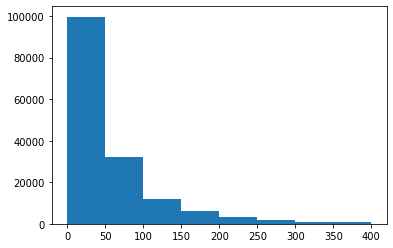

In [18]:
# finding the optimum value for maxlen of sentences
totalNumWords = [len(one_comment) for one_comment in list_tokenized_train]
plt.hist(totalNumWords,bins=np.arange(0,410,50))
plt.show()

In [19]:
# padding to make all sentences of equal length
maxlen=100
xtrain=pad_sequences(list_tokenized_train,maxlen=maxlen)
xtest=pad_sequences(list_tokenized_test,maxlen=maxlen) 

Building the LSTM neural network model for classification

the inputs into our networks are our list of encoded sentences. We begin our defining an Input layer that accepts a list of sentences that has a dimension of 100.By indicating an empty space after comma, we are telling Keras to infer the number automatically
Next, we pass it to our Embedding layer, where we project the words to a defined vector space depending on the distance of the surrounding words in a sentence.Embedding layer create svector representations for words, it outputs list of vectors for words for each sentence

before we could pass the output of LSTM to a normal layer, we need to reshape the 3D tensor into a 2D one. we will use GlobalMaxPool
Pooling layers are used for dimensionlity reduction

With a 2D Tensor in our hands, we pass it to a Dropout layer which indiscriminately "disable" some nodes so that the nodes in the next layer is forced to handle the representation of the missing data and the whole network could result in better generalization.

After a drop out layer, we connect the output of drop out layer to a densely connected layer and the output passes through a RELU function

Finally, we feed the output into a Sigmoid layer. The reason why sigmoid is used is because we are trying to achieve a binary classification(1,0) for each of the 6 labels, and the sigmoid function will squash the output between the bounds of 0 and 1.



In [20]:
# input layer
inp=Input(shape=(maxlen,))   # 100
embed_size=128
x=Embedding(max_features,embed_size)(inp)    # outputs tensor of shape (none,input_shape,embed_size)
x=LSTM(100,return_sequences=True,name='lstm-layer1')(x)
x=GlobalMaxPool1D()(x)
x=Dropout(0.1)(x)
x = Dense(50, activation="relu")(x)
x = Dropout(0.1)(x)
x = Dense(6, activation="sigmoid")(x)

In [21]:
model=Model(inputs=inp,outputs=x)
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

In [22]:
batch_size=32
epochs=2
model.fit(xtrain,y,batch_size=batch_size,validation_split=0.1,epochs=epochs) 

Epoch 1/2
4488/4488 [==============================] - 1743s 384ms/step - loss: 0.0996 - accuracy: 0.8709 - val_loss: 0.0506 - val_accuracy: 0.9937
Epoch 2/2
4488/4488 [==============================] - 1690s 377ms/step - loss: 0.0415 - accuracy: 0.9829 - val_loss: 0.0493 - val_accuracy: 0.9926


In [23]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 100, 128)          28006528  
_________________________________________________________________
lstm-layer1 (LSTM)           (None, 100, 100)          91600     
_________________________________________________________________
global_max_pooling1d (Global (None, 100)               0         
_________________________________________________________________
dropout (Dropout)            (None, 100)               0         
_________________________________________________________________
dense (Dense)                (None, 50)                5050      
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0     

In [24]:
model.predict(xtest[0])

array([[2.72840261e-03, 1.34421489e-05, 5.59836626e-04, 1.79439783e-04,
        2.87175179e-04, 1.38580799e-04],
       [2.72840261e-03, 1.34421489e-05, 5.59836626e-04, 1.79439783e-04,
        2.87175179e-04, 1.38580799e-04],
       [2.72840261e-03, 1.34421489e-05, 5.59836626e-04, 1.79439783e-04,
        2.87175179e-04, 1.38580799e-04],
       [2.72840261e-03, 1.34421489e-05, 5.59836626e-04, 1.79439783e-04,
        2.87175179e-04, 1.38580799e-04],
       [2.72840261e-03, 1.34421489e-05, 5.59836626e-04, 1.79439783e-04,
        2.87175179e-04, 1.38580799e-04],
       [2.72840261e-03, 1.34421489e-05, 5.59836626e-04, 1.79439783e-04,
        2.87175179e-04, 1.38580799e-04],
       [2.72840261e-03, 1.34421489e-05, 5.59836626e-04, 1.79439783e-04,
        2.87175179e-04, 1.38580799e-04],
       [2.72840261e-03, 1.34421489e-05, 5.59836626e-04, 1.79439783e-04,
        2.87175179e-04, 1.38580799e-04],
       [2.72840261e-03, 1.34421489e-05, 5.59836626e-04, 1.79439783e-04,
        2.87175179e-04, 